In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds

tfkl = tfk.layers

### MNIST data
Here is some code to load the MNIST digit recognition dataet and associated metadata

In [2]:
data, info = tfds.load('mnist', with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



### Preprocessing

Let's start by writting a preprocessing function.

TensorFlow Datasets packages the MNIST data such that each element is a `dict` with two keys:
- `image`: an array containing the image with shape (28, 28, 1), values of type `uint8`, and values between 0 and 255
- `label`: An integer between 0 - 9 indicating the digit in the image

Write a `preprocess` function that takes in one such element and prepares it for training an autoencoder. Things to make sure your function does:
1. Cast the image to a `float32`
2. Scale the values of the images so they are between 0 - 1
3. Return a tuple with the transformed image and the label

Then write another function called `ae_targets` that transforms this $(x, y)$ pair into the tuple that represents the input and target that are appropriate for an autoencoder.

Finally, transform the originally dataset with the following steps:
1. Grab the training dataset
2. apply (i.e. "map") the preprocessing function
3. apply the function to generate appropriate autoencoder targets
3. cache the results (so you only to these tranformations the first time through the dataset)
4. split the dataset into batches of size `32`
5. set up the resulting dataset to repeat
6. set up the resulting dataset to prefetch `5` elements

(there is a chain of functions on the `Dataset` to do each of these!)

In [4]:
preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])
ae_targets = lambda x, y: (x, x)

ds_train = data['train'].map(preprocess).map(lambda x, y: (x, x)).cache().batch(32).repeat().prefetch(5)
    

### TensorFlow functional API + a simple autoencoder

We will want to use the encoder and decoder from our autoencoder separately down the road. Here is some code to build a simple autoencoder with a single hidden layer using the TensorFlow 'functional API' to see show we can combine two submodels (in this case the encoder and the decoder) into on larger model.

In [5]:
img_shape = info.features['image'].shape
print(img_shape)
print(np.prod(img_shape))

(28, 28, 1)
784


In [6]:
encoder = tfk.Sequential([
  tfkl.InputLayer(img_shape),
  tfkl.Flatten(),
  tfkl.Dense(32, activation=tf.nn.relu)
])
encoder.summary()

decoder = tfk.Sequential([
  tfkl.InputLayer(32),
  tfkl.Dense(np.prod(img_shape), activation=tf.nn.sigmoid),
  tfkl.Reshape(img_shape)
])
decoder.summary()

# the tf.keras function API starts with defining placeholder tensors that represent model inputs
x = tfkl.Input(img_shape)

# we can then pass this placeholder through our models to specify the computation to get a prediction
h = encoder(x)
xhat = decoder(h)

# finally we use the tfk.Model class instantiate the model by specifying the inputs and outputs
# (note: this can also be lists, which is how you make more complex models with multiple inputs and/or outputs)
autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

# training happens as usual
autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
)

results = autoencoder.fit(ds_train, steps_per_epoch=400, epochs=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               25872     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________
Model: "functional_1"
____

400/400 [==============================] - 1s 4ms/step - loss: 0.2471
Epoch 2/20
400/400 [==============================] - 1s 3ms/step - loss: 0.1637
Epoch 3/20
400/400 [==============================] - 2s 4ms/step - loss: 0.1391
Epoch 4/20
400/400 [==============================] - 1s 3ms/step - loss: 0.1251
Epoch 5/20
400/400 [==============================] - 1s 3ms/step - loss: 0.1164
Epoch 6/20
400/400 [==============================] - 1s 2ms/step - loss: 0.1095
Epoch 7/20
400/400 [==============================] - 1s 2ms/step - loss: 0.1053
Epoch 8/20
400/400 [==============================] - 1s 2ms/step - loss: 0.1020
Epoch 9/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0997
Epoch 10/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0982
Epoch 11/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0963
Epoch 12/20
400/400 [==============================] - 1s 2ms/step - loss: 0.0962
Epoch 13/20
400/400 [===============

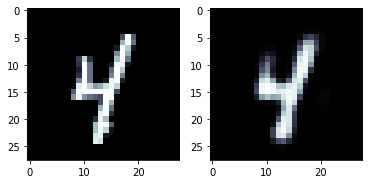

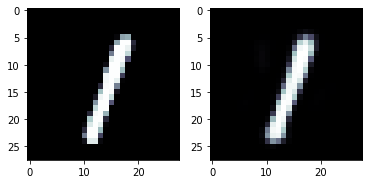

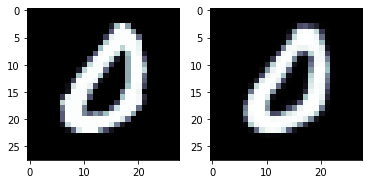

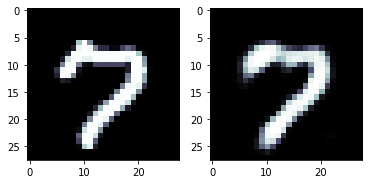

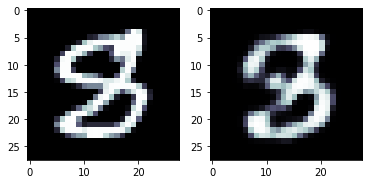

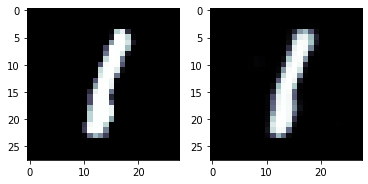

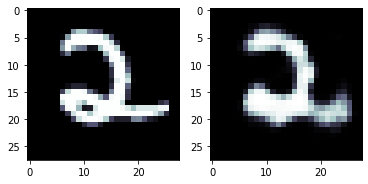

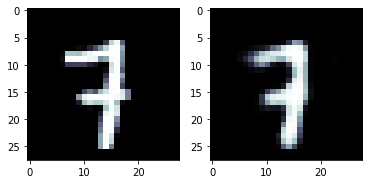

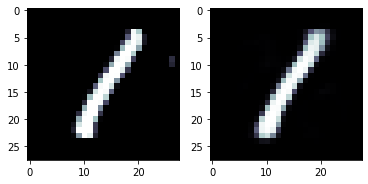

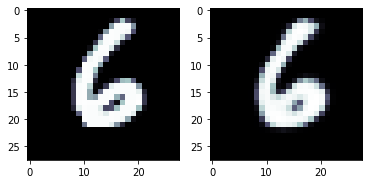

In [7]:
imgs = next(iter(ds_train))[0]
for i in range(10):
  plt.subplot(1, 2, 1)
  plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
  plt.subplot(1, 2, 2, )
  plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
  plt.show()

### Deep autoencoder and latent representations

We want to reduce the dimensionality to the hidden layer so that we can plot the hidden representations to see how the autoencoder is organizing the data. If our hidden layers is going to be so much smaller, we will need to make up for it by making the network deeper.

Modify the code above to make this work. Try a layers of size 156 -> 32 -> 2. After trining the model, use the encoder by itself and make a scatter plot of the some of the data, coloring each point by the digit identity. Which digits end up bunched together? Which are more well separated? Why might this be?

In [ ]:
# your code here

In [ ]:
for i in range(10):
  plt.subplot(1, 2, 1)
  plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
  plt.subplot(1, 2, 2, )
  plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
  plt.show()

In [ ]:
# get 1000 data points for the scatter plot
x, y = next(iter(data['test'].map(preprocess).batch(1000)))

In [ ]:
# your code here -- run the data through the encoder and scatter plot the results